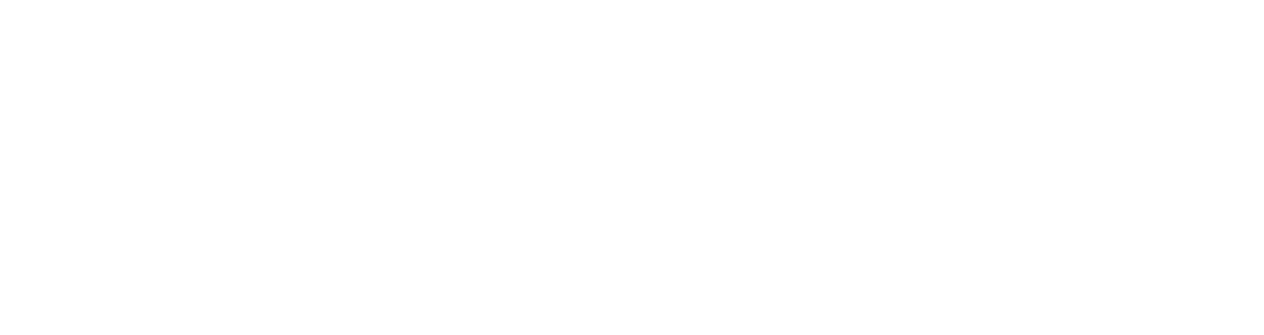

# QuadReal Challenge
### What is this notebook for?
This notebook will provide an introductory example to working with the data provided for the QuadReal Challenge.

Note that the work done in this notebook is very introductory and leaves a lot of room for improvement when it comes to model selection and data preprocessing!

**The guide assumes that you have the notebook downloaded and working with local data. Make sure you change `BASE_PATH` to the path of your downloaded dataset**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

BASE_PATH = "" # CHANGE THIS TO THE ABSOLUTE PATH OF THE DATASET ON YOUR DEVICE

In [4]:
devices = pd.read_csv(f"{BASE_PATH}devices.csv")
readings = pd.read_csv(f"{BASE_PATH}sampled_readings.csv")
reading_types = pd.read_csv(f"{BASE_PATH}reading_types.csv")

Since this dataset does not contain a lot of features, it is recommended that you add features. In this example, an external dataset of temperatures is used. This dataset is not provided

In [5]:
#temps = pd.read_csv(f"{BASE_PATH}/temps.csv")
#reduced_temps = temps[['Mean Temp (°C)','Date/Time']].rename(columns={"Date/Time":"date"})
#reduced_temps.loc[:,"date"] = reduced_temps["date"].astype(str)

FileNotFoundError: [Errno 2] No such file or directory: '/temps.csv'

We merge `devices.csv` and `sampled_readings.csv` so that the readings set would contain building ID data

In [6]:
devices["device_id"] = devices["device_id"].astype(int)
readings["device_id"] = readings["device_id"].astype(int)

df = readings.join(devices, on="device_id", how="left", lsuffix="_l")

This cell merges the temperature and reading datasets by the date

With dates, we can extract different types of features from it. One thing that we can do is turn the date into the day of the month, or day of the week.

In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dow'] = df['date'].dt.dayofweek

We often split a dataset into 3 sets to test the performance:
- Train: the dataset that we train with
- Validation: the dataset that we evaluate the training with, often during training, to prevent overfitting
- Test: the dataset that we test with
<br/><br/>
In this challenge, the test set is unknown, so it is recommended that you split the train set into train and val to evaluate whether your ideas are making progress.

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2)

In [ ]:
val_df.to_csv("./val_set.csv", index=False)

Since most regression models can only predict from 0 to 1, we have to set the predicted values between 0-1 (we call this normalization). Since each sensor has a different range, it is better to not normalize all sensor values together. Instead, we find each sensor's range and normalize from there <br/><br/>
We also save a `stat_dict` so we can use the same values to normalize the test set

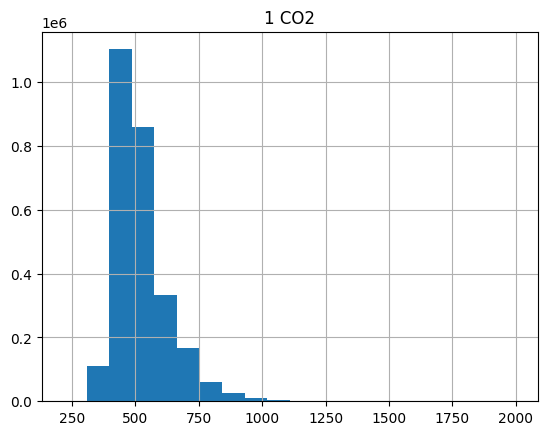

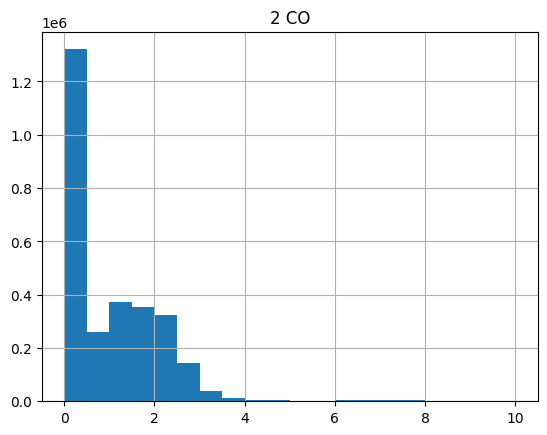

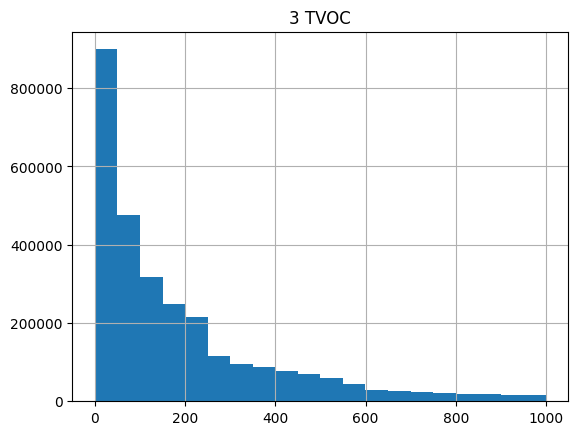

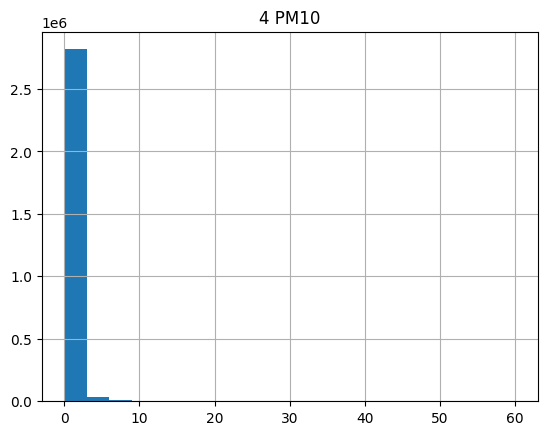

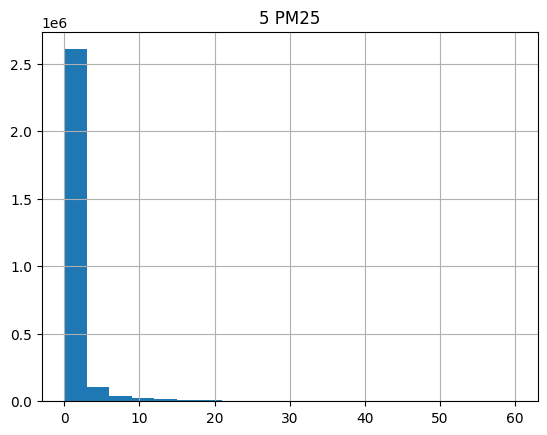

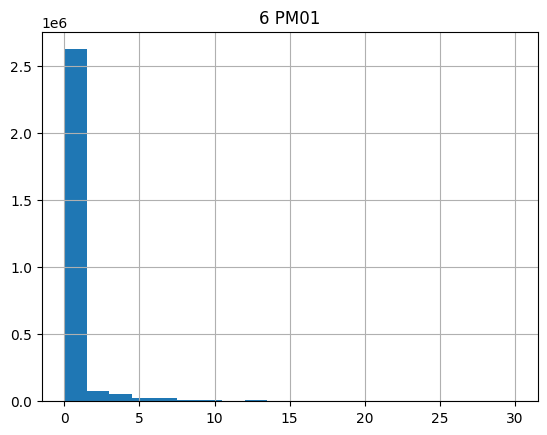

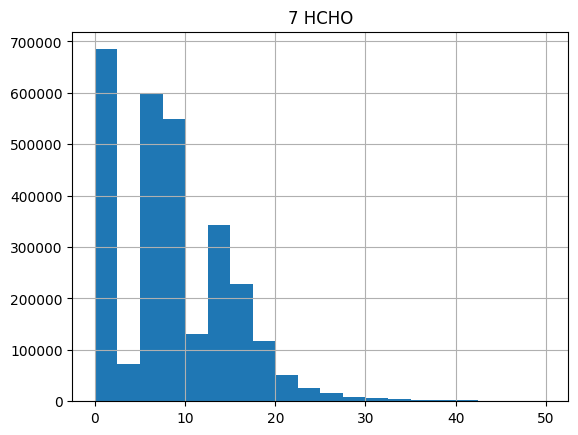

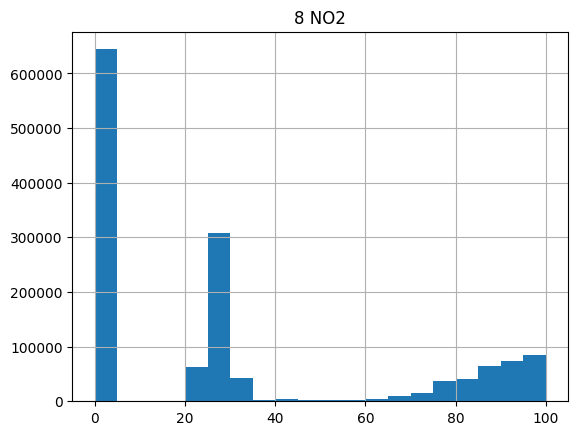

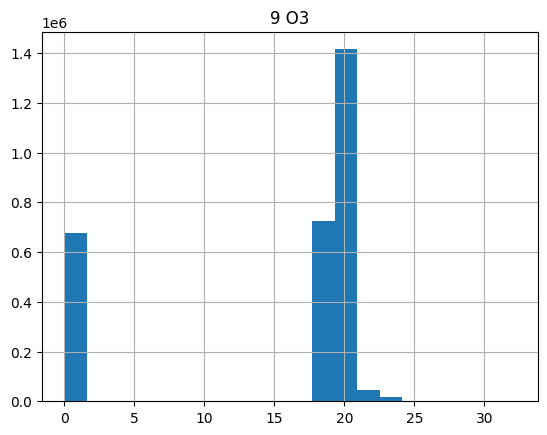

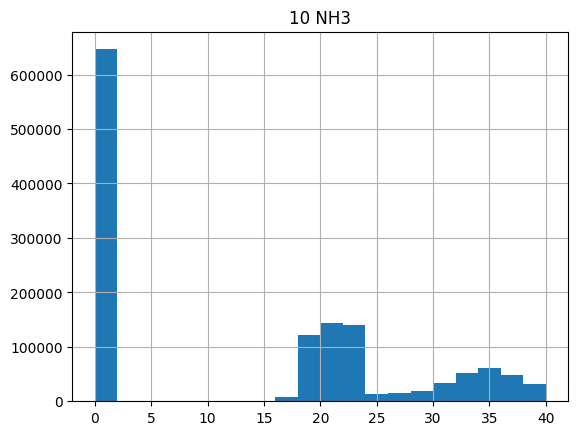

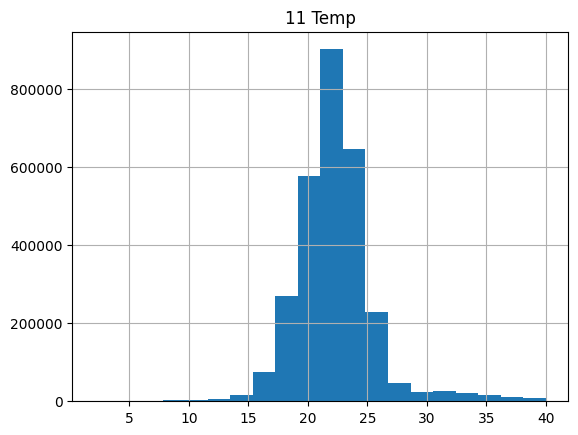

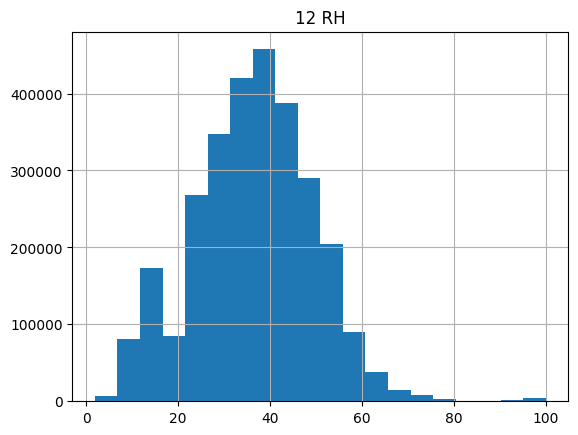

In [ ]:
stat_dict = {}

VALUE_TYPE_MAX = reading_types["reading_type_id"].max()

for idx in range(1,VALUE_TYPE_MAX+1):
    curr_vals = train_df[train_df["value_type_id"]==idx]["value"]
    curr_name = reading_types.iloc[idx-1].reading_type_name
    stat_dict[curr_name] = [curr_vals.min(), curr_vals.max()]
    train_df.loc[train_df["value_type_id"] == idx, "value"] = (curr_vals - curr_vals.min())/(curr_vals.max()-curr_vals.min())
    curr_vals.hist(bins=20)
    plt.title(f"{idx} {curr_name}")
    plt.show()

In [ ]:
stat_dict

{'CO2': [219.0, 1998.2],
 'CO': [0.0, 10.0],
 'TVOC': [0.0, 999.6],
 'PM10': [0.0, 60.0],
 'PM25': [0.0, 60.0],
 'PM01': [0.0, 30.0],
 'HCHO': [0.0, 50.0],
 'NO2': [0.0, 100.0],
 'O3': [0.0, 32.2],
 'NH3': [0.0, 40.0],
 'Temp': [2.1, 40.0],
 'RH': [1.9, 100.0]}

In [ ]:
train_df.to_csv("processed_readings.csv", index=False)

We reload the processed and saved dataset from here

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
BASE_PATH = "C://Users//alvin//DATA//dsc//cxc_iii//quadreal"

In [ ]:
train_df = pd.read_csv(f"{BASE_PATH}/processed_readings.csv")
reading_types = pd.read_csv(f"{BASE_PATH}/reading_types.csv")
val_df = pd.read_csv(f"{BASE_PATH}/val_set.csv")

Some models cannot process NA values, so we fill those NAs with 0. There are multiple ways you can deal with NA values, and filling them with 0s is oftenly not the best. <br/><br/>
In this cell, we also cast all columns to be `int` so that it takes less memory to process the columns

In [ ]:
train_df = train_df.fillna(0)
val_df = val_df.fillna(0)
train_df["value"] = train_df["value"].astype(np.float16)

In [ ]:
stat_dict = {'CO2': [219.0, 1998.2],
 'CO': [0.0, 10.0],
 'TVOC': [0.0, 999.6],
 'PM10': [0.0, 60.0],
 'PM25': [0.0, 60.0],
 'PM01': [0.0, 30.0],
 'HCHO': [0.0, 50.0],
 'NO2': [0.0, 100.0],
 'O3': [0.0, 32.2],
 'NH3': [0.0, 40.0],
 'Temp': [2.1, 40.0],
 'RH': [1.9, 100.0]}

In [ ]:
x_cols = ["device_id", "building_id", "Mean Temp (°C)", "month", "day", "dow", "value_type_id"]
y_col = "value"

X_train = train_df[x_cols]
y_train = train_df[y_col]

X_val = val_df[x_cols]
y_val = val_df[y_col]

In [ ]:
X_train = X_train.astype(int)
X_val = X_val.astype(int)

We are framing this as a tabular regression problem, and RandomForest is an alright model for that, so let's try that out <br/><br/>
This cell will take a long time, just sit back and take a sip of coffee 🍵

In [ ]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(max_depth=10, max_leaf_nodes=20, random_state=42)
clf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_leaf_nodes=20, random_state=42)

In [ ]:
import joblib
joblib.dump(clf, "model_01.pkl")

['model_01.pkl']

In [ ]:
y_val_pred = clf.predict(X_val)

Since the predicted values are normalized, we need to convert them to back to the normal range

In [ ]:
from tqdm import tqdm

all_y_val_preds = []
for val_type, pred in tqdm(zip(val_df["value_type_id"].tolist(), y_val_pred)):
    name = reading_types.iloc[val_type-1].reading_type_name
    adjusted_val = pred * (stat_dict[name][1] - stat_dict[name][0]) + stat_dict[name][0]
    all_y_val_preds.append(adjusted_val)

7800845it [05:45, 22557.12it/s]


In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(all_y_val_preds, y_val)

In [ ]:
all_y_val_preds[:10], y_val[:10]

([459.366785389877,
  47.4861324190168,
  491.2104304864433,
  0.4116913953990955,
  33.7859435541968,
  0.823382790798191,
  1.5299597037232648,
  8.899239970386311,
  5.09153384521257,
  18.337516595729348],
 0    517.5
 1     50.3
 2    460.0
 3      0.0
 4     25.4
 5      0.0
 6      3.0
 7     20.2
 8     32.8
 9     19.2
 Name: value, dtype: float64)

In [ ]:
mse

5059.438935175895

We have to do the same preprocessing for the test set, that we did on the train set

In [ ]:
test_set = pd.read_csv(f"{BASE_PATH}/test.csv", header=None, names=["device_id", "date", "value_type_id"])
temps = pd.read_csv(f"{BASE_PATH}/temps.csv")
devices = pd.read_csv(f"{BASE_PATH}/devices.csv")

reduced_temps = temps[['Mean Temp (°C)','Date/Time']].rename(columns={"Date/Time":"date"})
reduced_temps["date"] = reduced_temps["date"].astype(str)
devices["device_id"] = devices["device_id"].astype(int)
test_set["device_id"] = test_set["device_id"].astype(int)
test_set = test_set.join(devices, on="device_id", how="left", lsuffix="_l")
test_set["date"] = test_set["date"].astype(str).map(lambda x: str(x[:10]))
test_set = pd.merge(test_set, reduced_temps, on="date", how="left")
test_set['date'] = pd.to_datetime(test_set['date'], format='%Y-%m-%d')
test_set['month'] = test_set['date'].dt.month
test_set['day'] = test_set['date'].dt.day
test_set['dow'] = test_set['date'].dt.dayofweek
test_set = test_set.fillna(0)

In [ ]:
test_x = test_set[["device_id", "building_id", "Mean Temp (°C)", "month", "day", "dow", "value_type_id"]]
test_preds = clf.predict(test_x)

In [ ]:
final_preds = []
for val_type, pred in zip(test_set["value_type_id"].tolist(), test_preds):
    name = reading_types.iloc[val_type-1].reading_type_name
    adjusted_val = pred * (stat_dict[name][1] - stat_dict[name][0]) + stat_dict[name][0]
    final_preds.append(adjusted_val)

In [ ]:
test_set["value"] = final_preds
test_set.to_csv("submission.csv", index=False)